# Imports

In [1]:
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Helper functions

In [2]:
def project(data,comp):
  mean = np.mean(data, axis=0)
  Z = data - mean

  return np.dot(comp.T,Z.T).T

def knn(n_neighbors,train,y_train,test,y_test,con=False):
  knn =  KNeighborsClassifier(n_neighbors)
  knn.fit(train,y_train)
  y_pred = knn.predict(test)
  acc = accuracy_score(y_train,y_pred)
  if con:
    print('\nAccuracy:',acc,'\n')
    matrix = metrics.confusion_matrix(y_test, y_pred)
    display = metrics.ConfusionMatrixDisplay(matrix)
    display.plot()

  return acc

def display_data(data,y,title):
  print(f'\n{title}:')
  print(f'Data shape: {data.shape}')
  df = pd.DataFrame(data)
  df['Id'] = y

  sample = data[np.random.choice(data.shape[0],
                                  size=6,
                                  replace=False),:]

  print('\nSample from data:')
  plt.figure(figsize=(12,8))
  i=1
  for s in sample:
    plt.subplot(2,3,i)
    plt.imshow(s.reshape(112,92),cmap='gray')
    i+=1
  plt.show()

def plot(x,y,xl,yl):
  plt.plot(x,y,linestyle='--', marker='o', color='r', label='line with marker')
  plt.xlabel(xl)
  plt.ylabel(yl)
  plt.legend()
  plt.show()

def show_faces(imgs):
  plt.figure(figsize=(16,8))
  for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(imgs[:,i].reshape(112,92),cmap='gray')
  plt.show()

def dim(comp,train,test,alpha=False):
  if alpha:
    print(f'\n@ ɑlpha = {alpha}')
  print("\nReduction dimensions:",comp.shape[1])
  print("Train reduced dimensions:",train.T.shape)
  print("Test reduced dimensions:",test.T.shape)

# Data Matrix and Label Vector


Dataset:
Data shape: (400, 10304)

Sample from data:


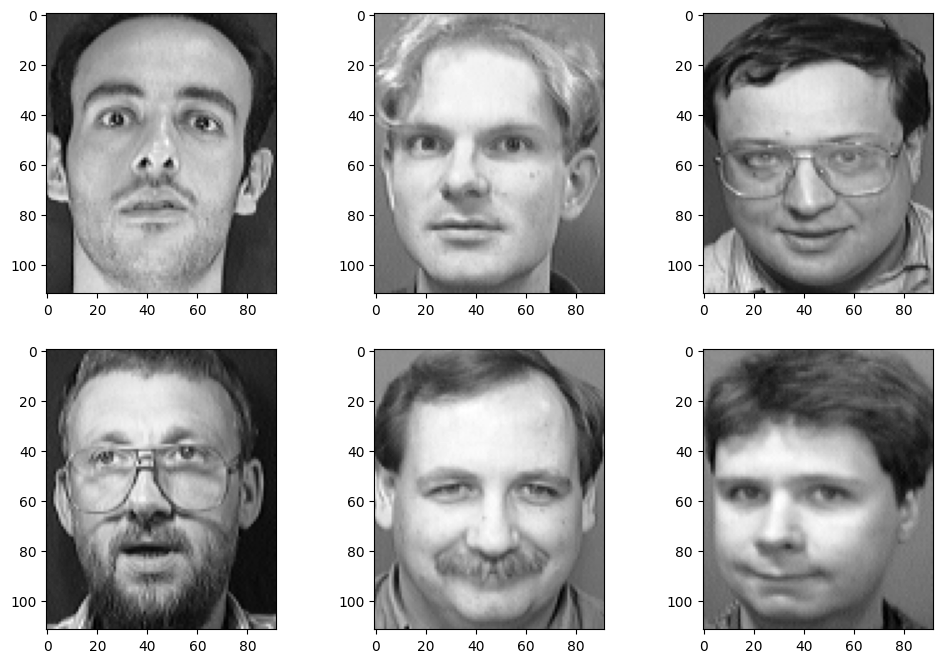

In [3]:
data = np.zeros(shape=(10304, ), dtype= np.int8)
y = np.array([])

for i in range(1,41):
  for j in range(1,11):
    img = Image.open(f'data/att/s{i}/{j}.pgm')
    imgData = np.asarray(img).reshape(-1)
    data = np.vstack((data,imgData))
    y = np.append(y,i)

y = y.astype('int8')
data = data[1:]

display_data(data,y,'Dataset')

# Data Split


Train data:
Data shape: (200, 10304)

Sample from data:


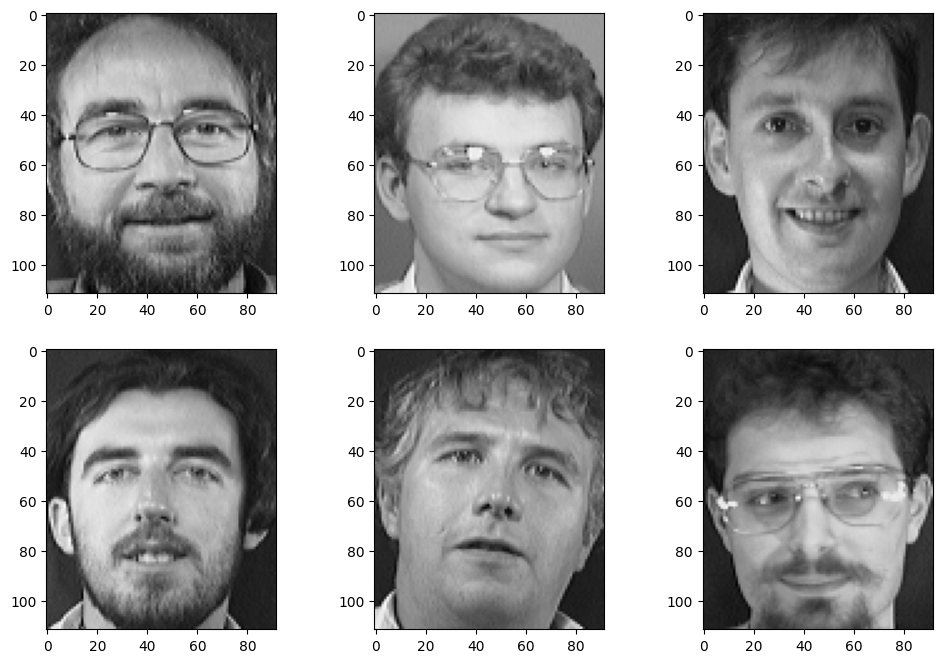


Test data:
Data shape: (200, 10304)

Sample from data:


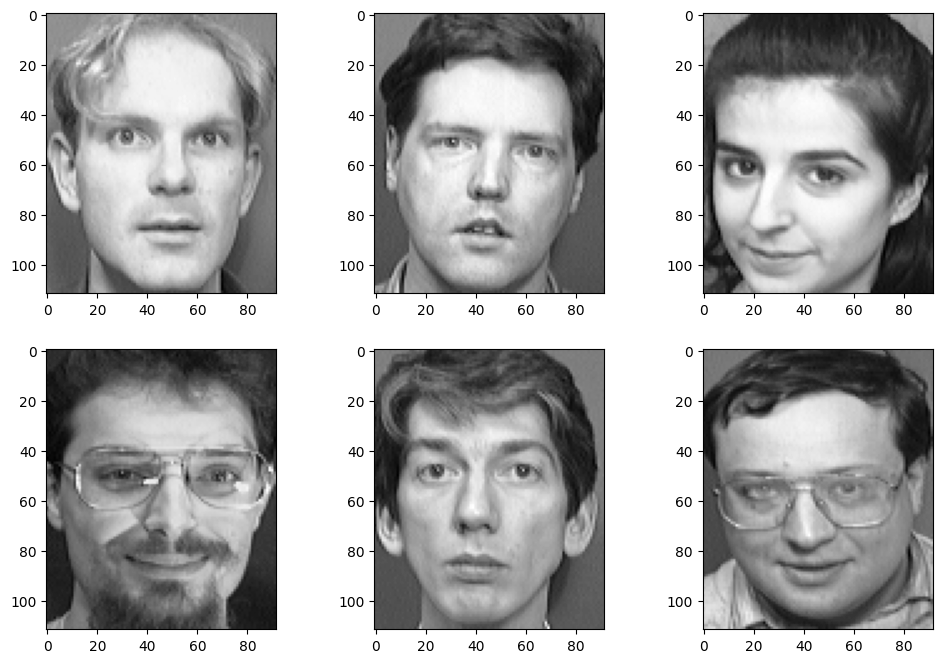

In [4]:
train, test, train_y, test_y = train_test_split(data, y, test_size=0.5, random_state=42,stratify = y)

display_data(train,train_y,'Train data')
display_data(test,test_y,'Test data')

# Classification using PCA

In [5]:
def PCA(data):
  # Step 1: Compute the mean of the data matrix X
  mean = np.mean(data, axis=0)

  # Step 2: Compute the centered data matrix Z
  Z = data - mean

  # Step 3: Compute the covariance matrix C
  C = np.cov(Z.T,bias=True) # Normalize by N

  # Step 4: Compute the eigenvalues and eigenvectors of C
  eigenvalues, eigenvectors = np.linalg.eigh(C)

  # Step 5: Sort the eigenvalues and eigenvectors in decreasing order of eigenvalues
  indices = np.argsort(eigenvalues)[::-1]
  eigenvalues = eigenvalues[indices]
  eigenvectors = eigenvectors[:, indices]

  return eigenvectors,eigenvalues

In [6]:
def find_R(eigenvectors,eigenvalues,alpha):
  # Step 6: Compute dimensions of reduction corresponding to given alpha value
  fr = 0
  sumEigens = sum(eigenvalues)
  r = 0

  while fr < alpha:
    r+=1
    fr = sum(eigenvalues[:r]) / sumEigens

  # Step 7: Choose the reduced basis
  return eigenvectors[:,:r]

In [7]:
# get the eigen faces
eigenvectors,eigenvalues = PCA(train)

Top 5 eigenfaces:



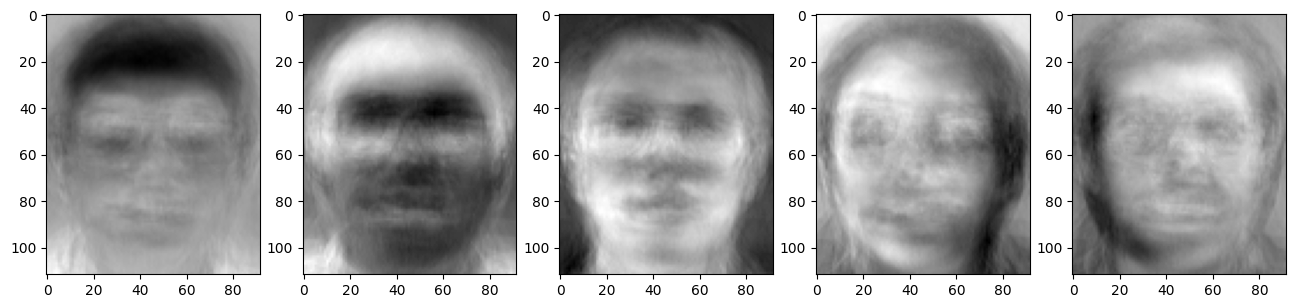

In [8]:
# a.Use the pseudo code below for computing the projection matrix U.
# Define the alpha = {0.8,0.85,0.9,0.95}

print('Top 5 eigenfaces:\n')
show_faces(eigenvectors[:,:5])

# compute reduction dimensions per alpha
U1 = find_R(eigenvectors,eigenvalues,0.8)

U2 = find_R(eigenvectors,eigenvalues,0.85)

U3 = find_R(eigenvectors,eigenvalues,0.9)

U4 = find_R(eigenvectors,eigenvalues,0.95)



In [9]:
# b. Project the training set, and test sets separately using the same
# projection matrix
train1 = project(train,U1)
test1 = project(test,U1)
dim(U1,train1,test1,0.8)


train2 = project(train,U2)
test2 = project(test,U2)
dim(U2,train2,test2,0.85)


train3 = project(train,U3)
test3 = project(test,U3)
dim(U3,train3,test3,0.9)


train4 = project(train,U4)
test4 = project(test,U4)
dim(U4,train4,test4,0.95)



@ ɑlpha = 0.8

Reduction dimensions: 35
Train reduced dimensions: (35, 200)
Test reduced dimensions: (35, 200)

@ ɑlpha = 0.85

Reduction dimensions: 51
Train reduced dimensions: (51, 200)
Test reduced dimensions: (51, 200)

@ ɑlpha = 0.9

Reduction dimensions: 75
Train reduced dimensions: (75, 200)
Test reduced dimensions: (75, 200)

@ ɑlpha = 0.95

Reduction dimensions: 114
Train reduced dimensions: (114, 200)
Test reduced dimensions: (114, 200)


# Classifier Tuning using K-NN =[1,3,5,7,9]

## PCA accuracy measure against number of neighbors

At k= 1 

Accuracy vector:  [0.045, 0.04, 0.04, 0.04] 




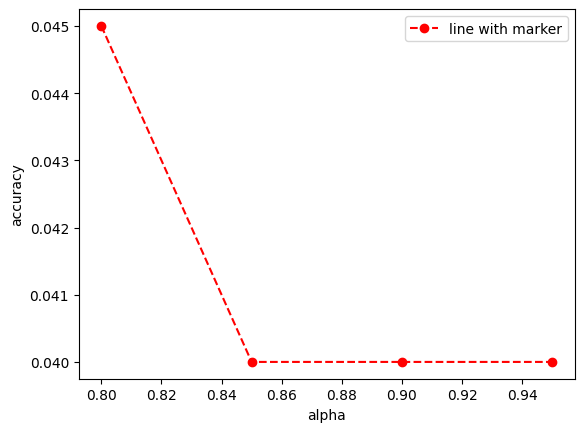

At k= 3 

Accuracy vector:  [0.045, 0.04, 0.04, 0.04] 




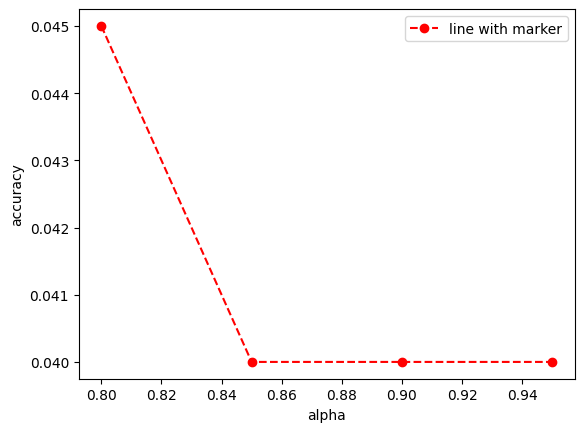

At k= 5 

Accuracy vector:  [0.035, 0.035, 0.04, 0.045] 




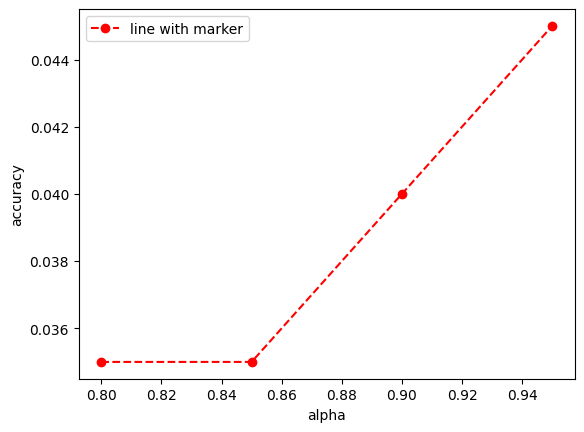

At k= 7 

Accuracy vector:  [0.04, 0.04, 0.05, 0.05] 




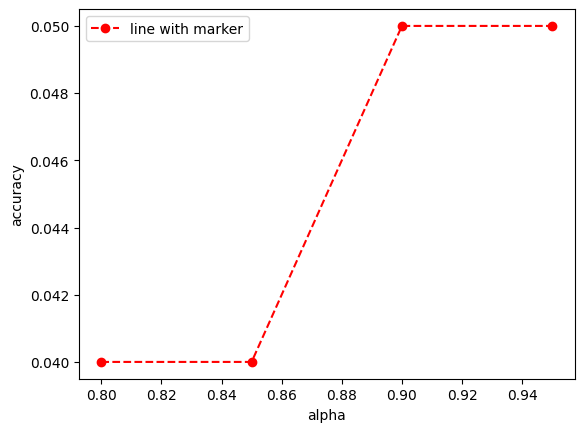

In [17]:
for neighbors in range(1,9,2):
  print("At k=",neighbors,"\n")
  acc1 = knn(neighbors,train1,train_y,test1,test_y)
  acc2 = knn(neighbors,train2,train_y,test2,test_y)
  acc3 = knn(neighbors,train3,train_y,test3,test_y)
  acc4 = knn(neighbors,train4,train_y,test4,test_y)
  accs = [acc1,acc2,acc3,acc4]
  print('Accuracy vector: ',accs,'\n\n')
  plot([0.8,0.85,0.9,0.95],accs,'alpha','accuracy')


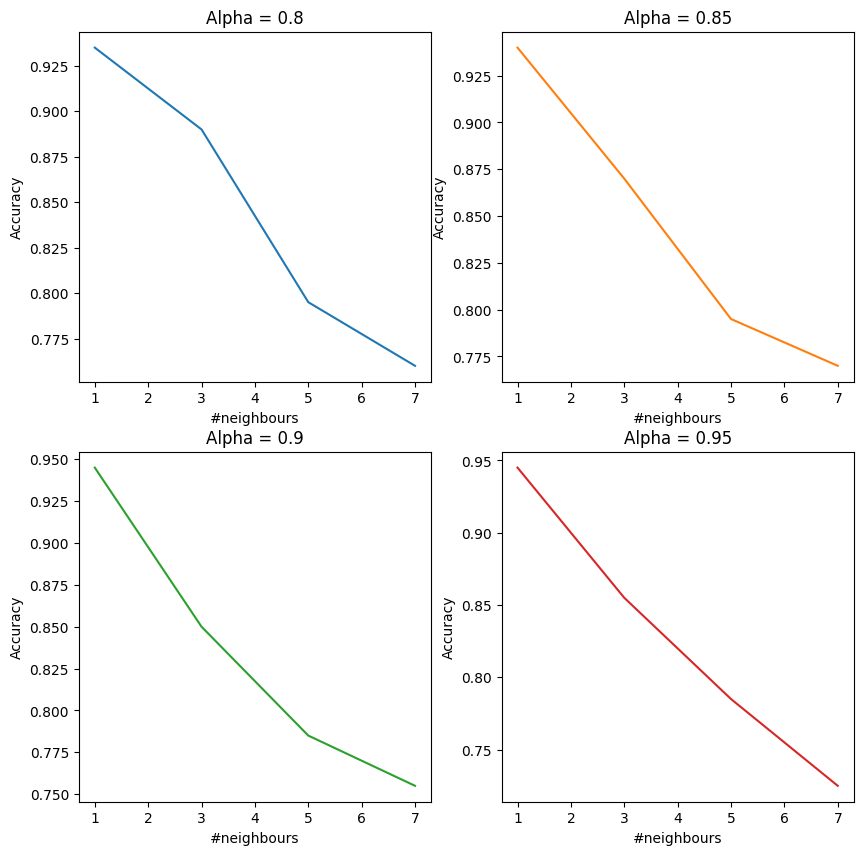

In [11]:
#for alpha=0.8
fig,axs=plt.subplots(2,2,figsize=(10,10))
PCA_y8=np.array([0.935,0.89,0.795,0.76])
PCA_x8=np.array([1,3,5,7])
axs[0,0].set_title("Alpha = 0.8")
axs[0,0].plot(PCA_x8,PCA_y8,'tab:blue')
axs[0,0].set_xlabel('#neighbours')
axs[0,0].set_ylabel('Accuracy')

#for alpha=0.85

PCA_y85=np.array([0.94,0.87,0.795,0.77])
PCA_x85=np.array([1,3,5,7])
axs[0,1].set_title("Alpha = 0.85")
axs[0,1].plot(PCA_x85,PCA_y85,'tab:orange')
axs[0,1].set_xlabel('#neighbours')
axs[0,1].set_ylabel('Accuracy')

#for alpha=0.9

PCA_y9=np.array([0.945,0.85,0.785,0.755])
PCA_x9=np.array([1,3,5,7])
axs[1,0].set_title("Alpha = 0.9")
axs[1,0].plot(PCA_x9,PCA_y9,'tab:green')
axs[1,0].set_xlabel('#neighbours')
axs[1,0].set_ylabel('Accuracy')

#for alpha=0.95

PCA_y95=np.array([0.945,0.855,0.785,0.725])
PCA_x95=np.array([1,3,5,7])
axs[1,1].set_title("Alpha = 0.95")
axs[1,1].plot(PCA_x95,PCA_y95,'tab:red')
axs[1,1].set_xlabel('#neighbours')
axs[1,1].set_ylabel('Accuracy')

plt.show()

# Bonus

## Data split


Train data:
Data shape: (280, 10304)

Sample from data:


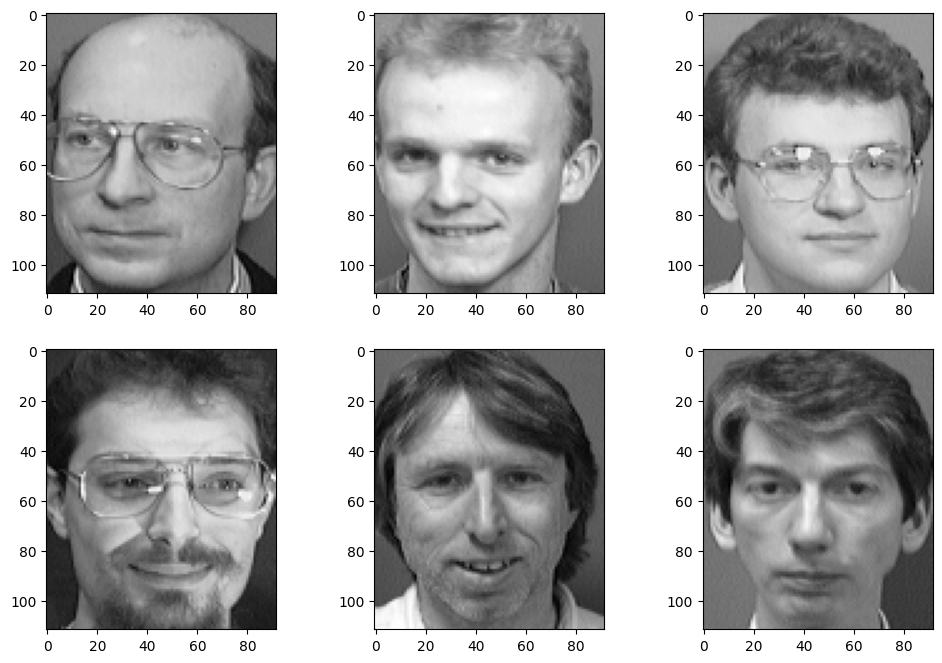


Test data:
Data shape: (120, 10304)

Sample from data:


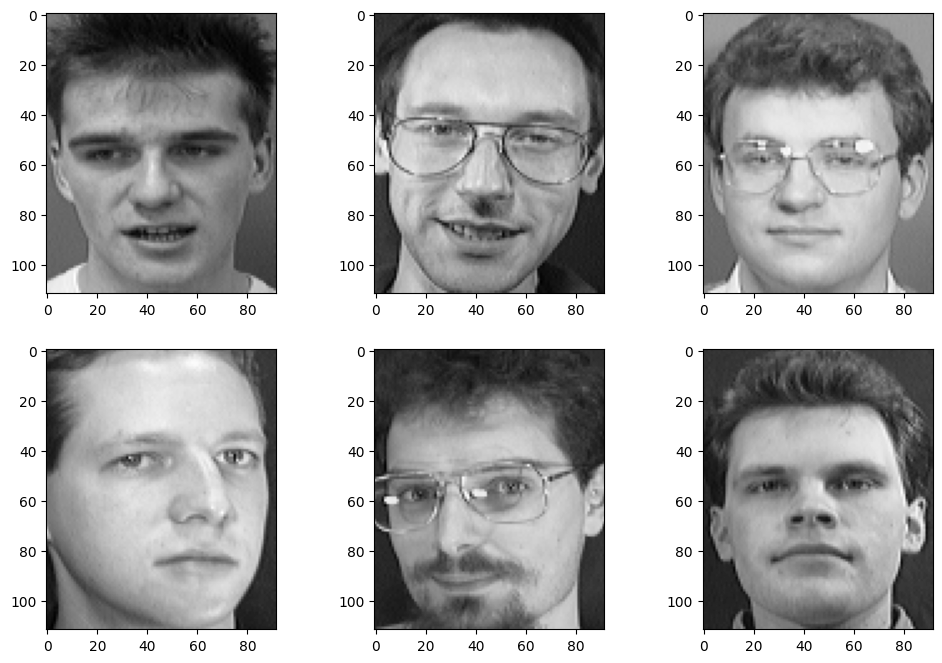

In [12]:
# a. Use different Training and Test splits. Change the number of instances per subject to be 7 and keep 3 instances per subject for testing. compare the results you have with the ones you got earlier with 50% split.
trainB, testB, trainB_y, testB_y = train_test_split(data, y, test_size=0.3, random_state=42,stratify = y)


display_data(trainB,trainB_y,'Train data')
display_data(testB,testB_y,'Test data')




## PCA

In [13]:
eigenvectors,eigenvalues = PCA(trainB)

Top 5 eigenfaces:



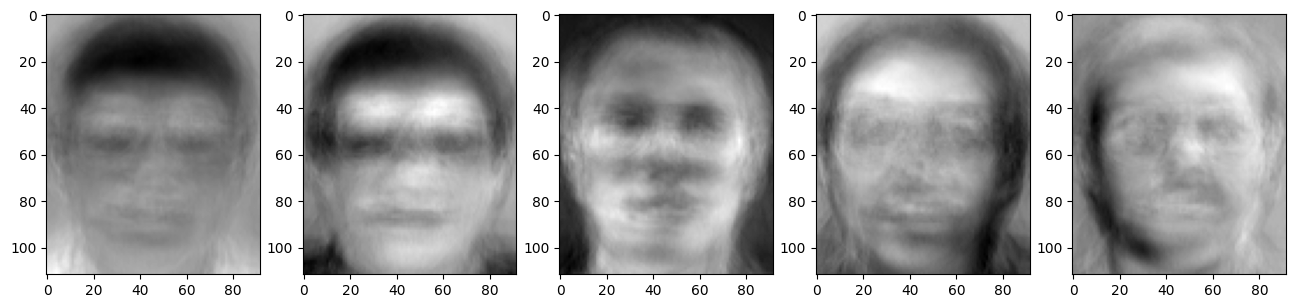

In [14]:
# a.Use the pseudo code below for computing the projection matrix U.
# Define the alpha = {0.8,0.85,0.9,0.95}

print('Top 5 eigenfaces:\n')
show_faces(eigenvectors[:,:5])
a
# compute reduction dimensions per alpha
U1B = find_R(eigenvectors,eigenvalues,0.8)

U2B = find_R(eigenvectors,eigenvalues,0.85)

U3B = find_R(eigenvectors,eigenvalues,0.9)

U4B = find_R(eigenvectors,eigenvalues,0.95)


In [15]:
# b. Project the training set, and test sets separately using the same
# projection matrix
train1B = project(trainB,U1B)
test1B = project(testB,U1B)
dim(U1B,train1B,test1B,0.8)

train2B = project(trainB,U2B)
test2B = project(testB,U2B)
dim(U2B,train2B,test2B,0.85)

train3B = project(trainB,U3B)
test3B = project(testB,U3B)
dim(U3B,train3B,test3B,0.9)

train4B = project(trainB,U4B)
test4B = project(testB,U4B)
dim(U4B,train4B,test4B,0.95)



@ ɑlpha = 0.8

Reduction dimensions: 40
Train reduced dimensions: (40, 280)
Test reduced dimensions: (40, 120)

@ ɑlpha = 0.85

Reduction dimensions: 59
Train reduced dimensions: (59, 280)
Test reduced dimensions: (59, 120)

@ ɑlpha = 0.9

Reduction dimensions: 91
Train reduced dimensions: (91, 280)
Test reduced dimensions: (91, 120)

@ ɑlpha = 0.95

Reduction dimensions: 148
Train reduced dimensions: (148, 280)
Test reduced dimensions: (148, 120)


# Classifier Tuning using K-NN =[1,3,5,7,9]

At k= 1 

Accuracy vector:  [0.045, 0.04, 0.04, 0.04] 




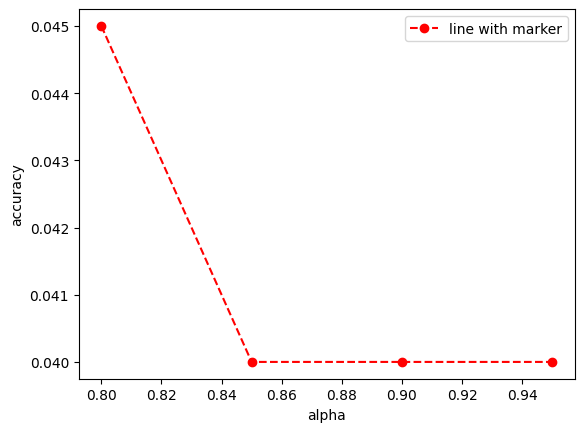

At k= 3 

Accuracy vector:  [0.045, 0.04, 0.04, 0.04] 




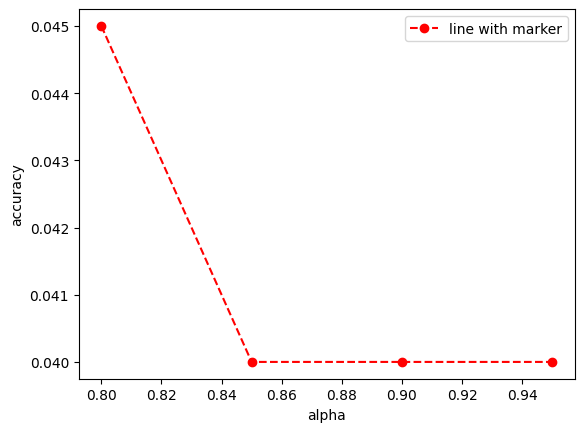

At k= 5 

Accuracy vector:  [0.035, 0.035, 0.04, 0.045] 




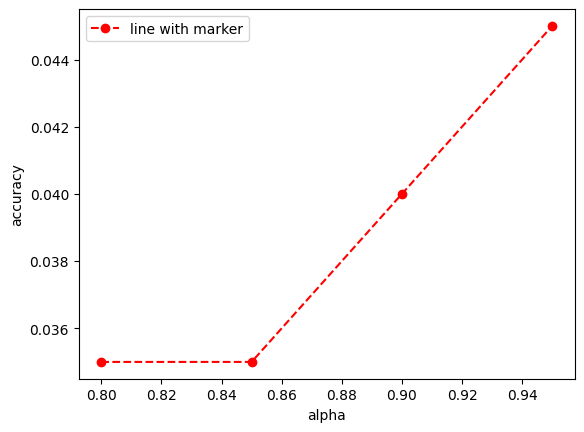

At k= 7 

Accuracy vector:  [0.04, 0.04, 0.05, 0.05] 




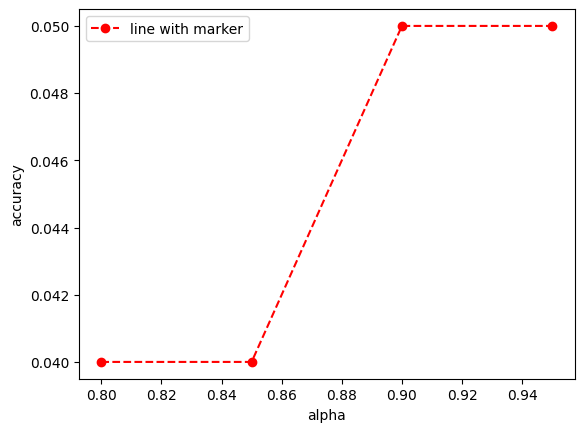

At k= 9 

Accuracy vector:  [0.045, 0.04, 0.04, 0.045] 




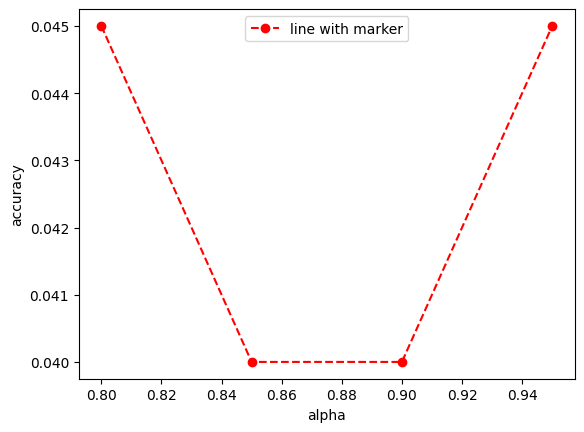

In [16]:
for neighbors in range(1,10,2):
  print("At k=",neighbors,"\n")
  acc1 = knn(neighbors,train1,train_y,test1,test_y)
  acc2 = knn(neighbors,train2,train_y,test2,test_y)
  acc3 = knn(neighbors,train3,train_y,test3,test_y)
  acc4 = knn(neighbors,train4,train_y,test4,test_y)
  accs = [acc1,acc2,acc3,acc4]
  print('Accuracy vector: ',accs,'\n\n')
  plot([0.8,0.85,0.9,0.95],accs,'alpha','accuracy')
